In [1]:
# importing modules and libraries

import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, ELU, Dense, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Nadam

2024-06-08 08:34:25.378667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 08:34:25.378766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 08:34:25.539390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5099 files belonging to 5 classes.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


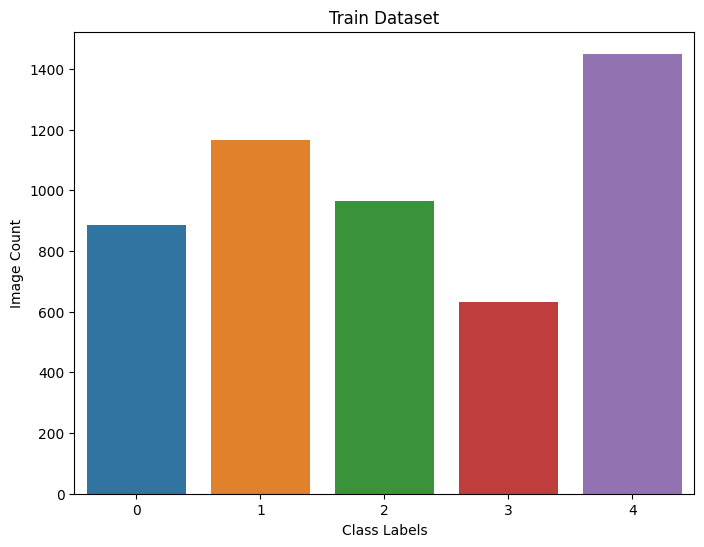

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Loading train and val datasets
train_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/pomegranate-fruit-diseases-dataset/Pomegranate Fruit Diseases Dataset for Deep Learning Models/Pomegranate Diseases Dataset/Pomegranate Diseases Dataset",
    image_size=(8, 8),
    batch_size=32
)

# Collecting class labels
train_labels = []
for _, labels in train_dataset:
    train_labels.extend(labels.numpy())

# Counting occurrences of each label
train_label_counts = Counter(train_labels)

# Plotting the counts
plt.figure(figsize=(8, 6))

sns.barplot(x=list(train_label_counts.keys()), y=list(train_label_counts.values()))
plt.title('Train Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Image Count')
plt.show()

In [2]:
# Loading train and val datasets
train_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/pomegranate-fruit-diseases-dataset/Pomegranate Fruit Diseases Dataset for Deep Learning Models/Pomegranate Diseases Dataset/Pomegranate Diseases Dataset",
    image_size=(224, 224),
    batch_size=32
)

# Normalizing datasets
normalization_layer = keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

# Converting the datasets to lists of images and labels
train_images = []
train_labels = []
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        train_images.append(image.numpy())
        train_labels.append(label.numpy())

# Converting to arrays
images = np.array(train_images)
labels = np.array(train_labels)

# Converting labels to probability distributions
labels = keras.utils.to_categorical(labels, 5)

Found 5099 files belonging to 5 classes.


In [3]:
# Split the data
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3,random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (3569, 224, 224, 3)
y_train: (3569, 5)
x_test: (765, 224, 224, 3)
y_test: (765, 5)
x_val: (765, 224, 224, 3)
y_val: (765, 5)


In [4]:
import gc # calling garbage collector to reduce memory utilization

del train_dataset

gc.collect()

317

In [5]:
from keras import mixed_precision # changing precision policies
mixed_precision.set_global_policy('mixed_float16')

In [6]:
import tensorflow as tf

tf.config.optimizer.set_jit(True) # setting optimizer to reduce model computation by optimizing graph-computations

### VGG16

In [7]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

# Loading model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block4_pool').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary() # printing summary of model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,165,701 (31.15 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.2389 - loss: 1.9137 

I0000 00:00:1717835794.145503     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717835794.172165     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5088 - loss: 1.3960

W0000 00:00:1717835808.902947     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.85752, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 224ms/step - accuracy: 0.5104 - loss: 1.3912 - val_accuracy: 0.8575 - val_loss: 0.4916 - learning_rate: 0.0010
Epoch 2/20
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8196 - loss: 0.5174
Epoch 2: val_accuracy improved from 0.85752 to 0.89935, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8199 - loss: 0.5167 - val_accuracy: 0.8993 - val_loss: 0.3229 - learning_rate: 0.0010
Epoch 3/20
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8739 - loss: 0.3810
Epoch 3: val_accuracy improved from 0.89935 to 0.91765, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8741 - loss: 0.3807 - val_accuracy: 0.9176 - val_loss: 0.2902 - learning_rate: 0.0010
Epoch 4/20
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8885 - loss: 0.3205
Epoch 4: val_accuracy improved from 0.91765 to 0.92941, saving model to m

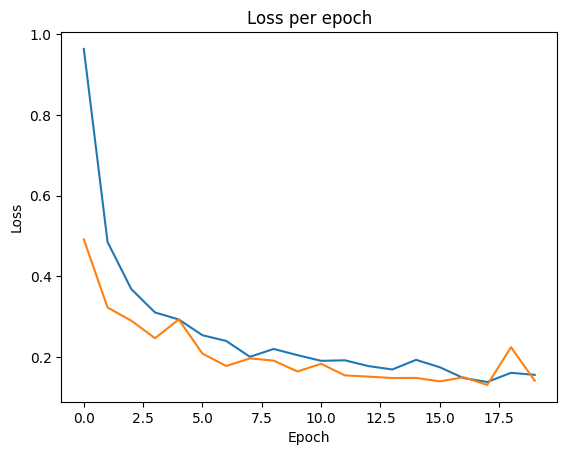

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

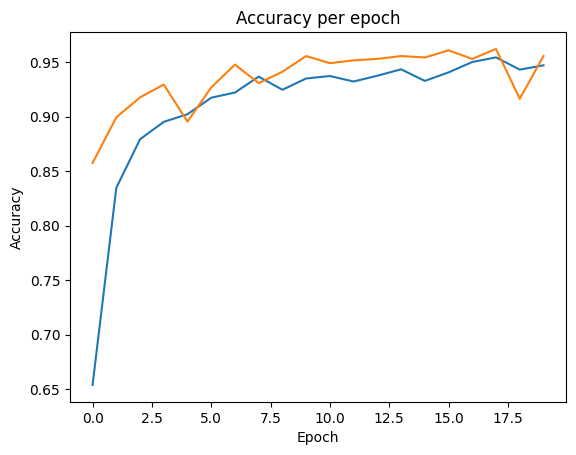

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### ResNet50

In [11]:
from keras.applications import ResNet50
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer('conv4_block3_out').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

# Setting callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 210,750,853 (803.95 MB)

 Trainable params: 205,527,045 (784.02 MB)

 Non-trainable params: 5,223,808 (19.93 MB)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.1740 - loss: 11.4466

W0000 00:00:1717836004.338526     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.18431, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 70s 599ms/step - accuracy: 0.1739 - loss: 11.4624 - val_accuracy: 0.1843 - val_loss: 13.1473 - learning_rate: 0.0010
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1822 - loss: 13.1721
Epoch 2: val_accuracy improved from 0.18431 to 0.20523, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 366ms/step - accuracy: 0.1822 - loss: 13.1716 - val_accuracy: 0.2052 - val_loss: 12.8102 - learning_rate: 0.0010
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1783 - loss: 13.2443
Epoch 3: val_accuracy did not improve from 0.20523
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.1784 - loss: 13.2430 - val_accuracy: 0.2052 - val_loss: 12.8102 - learning_rate: 0.0010
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1736 - loss: 13.3194
Epoch 4: val_accuracy did not improve from 0.20523
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - ac

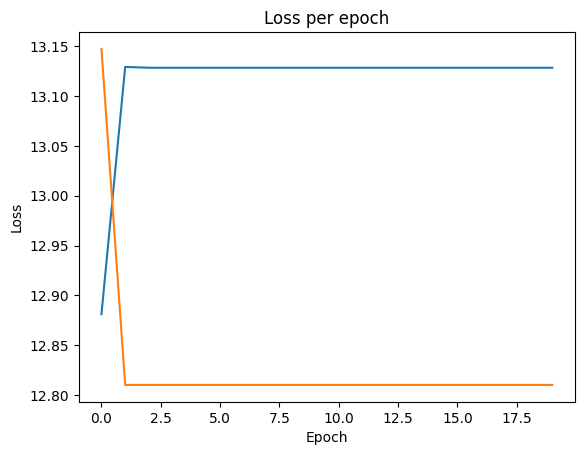

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

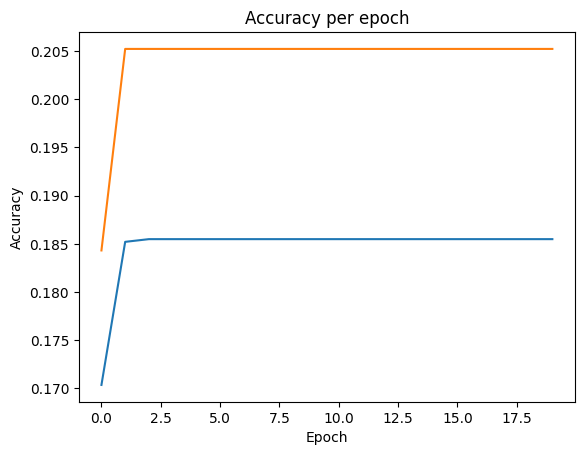

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### DenseNet121

In [15]:
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
densenet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=densenet121_model.input, outputs=densenet121_model.get_layer('conv5_block6_concat').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False
    
# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 6,267,333 (23.91 MB)

 Trainable params: 727,045 (2.77 MB)

 Non-trainable params: 5,540,288 (21.13 MB)

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 3/90 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.2625 - loss: 1.5716 

W0000 00:00:1717836265.978286     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.6321 - loss: 1.0617

W0000 00:00:1717836299.663018     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.95686, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 89s 572ms/step - accuracy: 0.6340 - loss: 1.0578 - val_accuracy: 0.9569 - val_loss: 0.2476 - learning_rate: 0.0010
Epoch 2/20
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9553 - loss: 0.2259
Epoch 2: val_accuracy improved from 0.95686 to 0.96863, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9553 - loss: 0.2252 - val_accuracy: 0.9686 - val_loss: 0.1329 - learning_rate: 0.0010
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9653 - loss: 0.1366
Epoch 3: val_accuracy did not improve from 0.96863
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9653 - loss: 0.1366 - val_accuracy: 0.9621 - val_loss: 0.1093 - learning_rate: 0.0010
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9659 - loss: 0.1226
Epoch 4: val_accuracy did not improve from 0.96863
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9

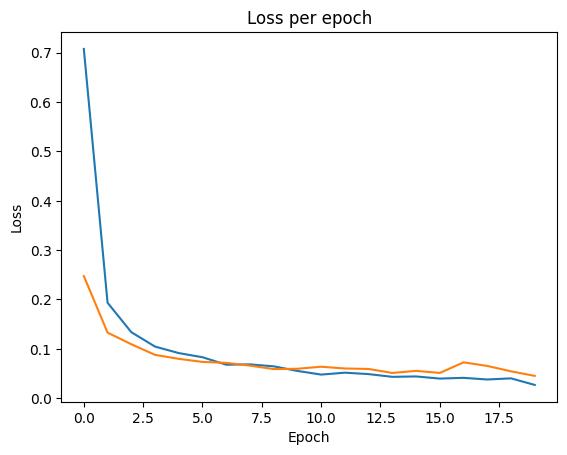

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

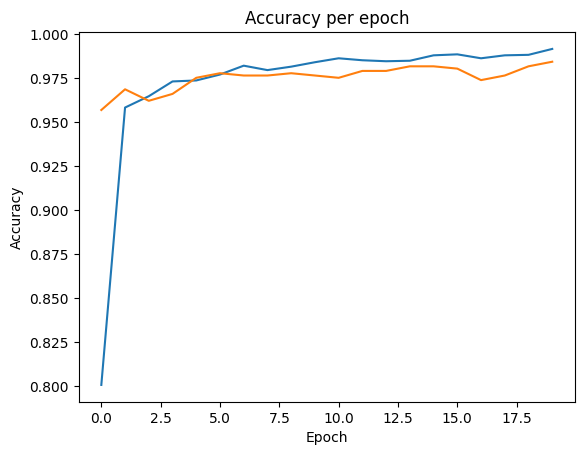

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Xception

In [23]:
from keras.applications import Xception
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=xception_model.input, outputs=xception_model.get_layer('block14_sepconv2_act').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_5[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_24[0][0]    

 Total params: 22,964,781 (87.60 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7369 - loss: 0.7459
Epoch 1: val_accuracy improved from -inf to 0.95686, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 282ms/step - accuracy: 0.7383 - loss: 0.7421 - val_accuracy: 0.9569 - val_loss: 0.1308 - learning_rate: 0.0010
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9440 - loss: 0.1677
Epoch 2: val_accuracy did not improve from 0.95686
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9440 - loss: 0.1677 - val_accuracy: 0.9556 - val_loss: 0.1227 - learning_rate: 0.0010
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9367 - loss: 0.1747
Epoch 3: val_accuracy improved from 0.95686 to 0.96340, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9368 - loss: 0.1744 - val_accuracy: 0.9634 - val_loss: 0.1481 - learning_rate: 0.0010
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9628 - loss: 0.0992
Epoch 4: val_accuracy

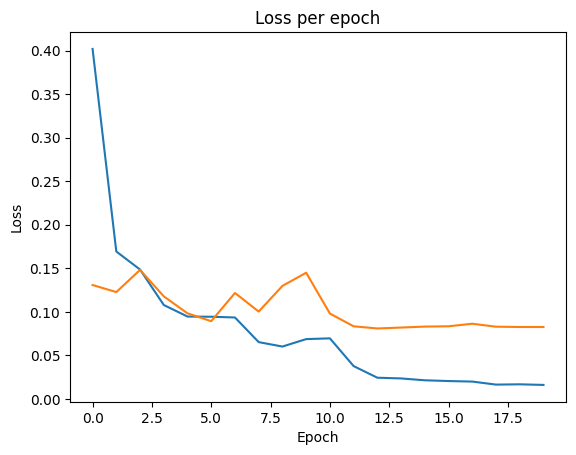

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

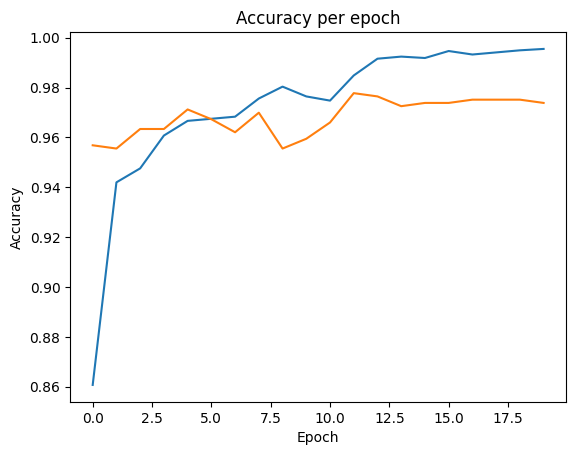

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Inception

In [27]:
from keras.applications import InceptionV3
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.get_layer('mixed10').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5742 - loss: 2.0174
Epoch 1: val_accuracy improved from -inf to 0.91373, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 65s 433ms/step - accuracy: 0.5763 - loss: 2.0067 - val_accuracy: 0.9137 - val_loss: 0.2395 - learning_rate: 0.0010
Epoch 2/20
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9387 - loss: 0.1853
Epoch 2: val_accuracy improved from 0.91373 to 0.94510, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9387 - loss: 0.1854 - val_accuracy: 0.9451 - val_loss: 0.1542 - learning_rate: 0.0010
Epoch 3/20
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9533 - loss: 0.1314
Epoch 3: val_accuracy did not improve from 0.94510
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9532 - loss: 0.1319 - val_accuracy: 0.9386 - val_loss: 0.2055 - learning_rate: 0.0010
Epoch 4/20
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9584 - loss: 0.1301
Epoch 4: val_accuracy

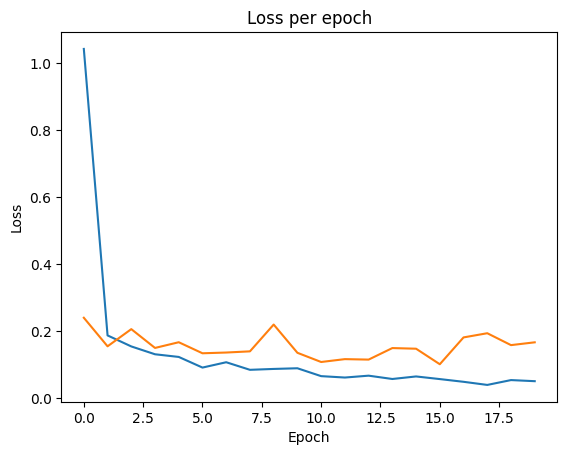

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

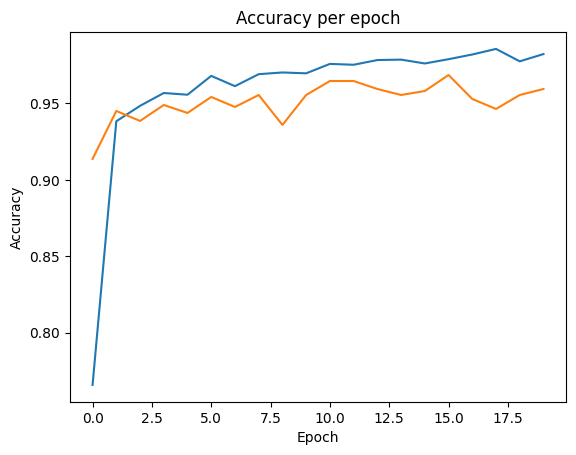

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### MobileNet

In [31]:
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading MobileNet model
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.get_layer('conv_pw_13_relu').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)

# Binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary()  # model summary


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,283,589 (16.34 MB)

 Trainable params: 1,054,725 (4.02 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 7/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2129 - loss: 2.6208

W0000 00:00:1717836909.449683     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5807 - loss: 1.6336

W0000 00:00:1717836920.149594     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.96863, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 163ms/step - accuracy: 0.5831 - loss: 1.6242 - val_accuracy: 0.9686 - val_loss: 0.0916 - learning_rate: 0.0010
Epoch 2/20
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9596 - loss: 0.1115
Epoch 2: val_accuracy improved from 0.96863 to 0.97516, saving model to model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9597 - loss: 0.1117 - val_accuracy: 0.9752 - val_loss: 0.0751 - learning_rate: 0.0010
Epoch 3/20
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9661 - loss: 0.1042
Epoch 3: val_accuracy did not improve from 0.97516
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9661 - loss: 0.1040 - val_accuracy: 0.9542 - val_loss: 0.1544 - learning_rate: 0.0010
Epoch 4/20
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9713 - loss: 0.0987
Epoch 4: val_accuracy did not improve from 0.97516
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9

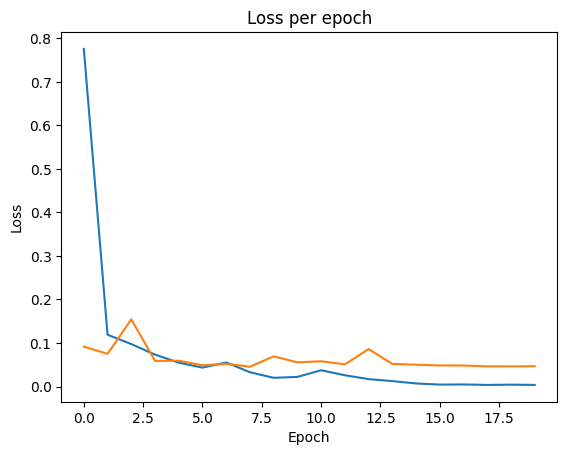

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

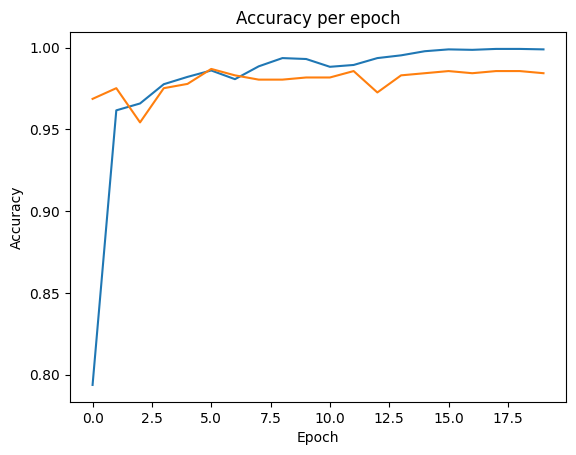

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### CNN

In [47]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, InputLayer
from keras.regularizers import l1_l2

model = Sequential()

model.add(InputLayer(shape=(224, 224, 3))) # input layer

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=l1_l2(0.001,0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=l1_l2(0.001,0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=l1_l2(0.001,0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=l1_l2(0.0001,0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D()) # pooling down

model.add(Dense(1024, activation='relu')) # dense layer
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) # output layer

model.summary() # model summary

# model checkpoint callback
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_118 (Conv2D)             │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_119         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_121         │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,285 (723.77 KB)

 Trainable params: 184,773 (721.77 KB)

 Non-trainable params: 512 (2.00 KB)

In [48]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=75,callbacks=[model_checkpoint])

Epoch 1/30


2024-06-08 09:06:40.198608: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[64,3,3,4]{3,2,1,0}, u8[0]{0}) custom-call(f16[75,224,224,4]{3,2,1,0}, f16[75,224,224,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-08 09:06:45.470461: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6.272086453s
Trying algorithm eng0{} for conv (f16[64,3,3,4]{3,2,1,0}, u8[0]{0}) custom-call(f16[75,224,224,4]{3,2,1,0}, f16[75,224,224,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-08 09:06:48.424584: E external/loca

47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6650 - loss: 3.5598

2024-06-08 09:09:09.049431: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[44,112,112,64]{3,2,1,0}, f16[44,112,112,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-08 09:09:11.272692: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.223367327s
Trying algorithm eng19{} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[44,112,112,64]{3,2,1,0}, f16[44,112,112,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-08 09:09:12.272889: E externa

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6674 - loss: 3.5487  
Epoch 1: val_accuracy improved from -inf to 0.19869, saving model to model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.6697 - loss: 3.5381 - val_accuracy: 0.1987 - val_loss: 4.8613
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8731 - loss: 2.1640
Epoch 2: val_accuracy did not improve from 0.19869
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8735 - loss: 2.1602 - val_accuracy: 0.1987 - val_loss: 5.0329
Epoch 3/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9018 - loss: 1.6048
Epoch 3: val_accuracy did not improve from 0.19869
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9018 - loss: 1.6011 - val_accuracy: 0.1987 - val_loss: 7.3521
Epoch 4/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9307 - loss: 1.2479
Epoch 4: val_accuracy did not improve from 0.19869
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9309 - loss: 1.2444 - val_accuracy:

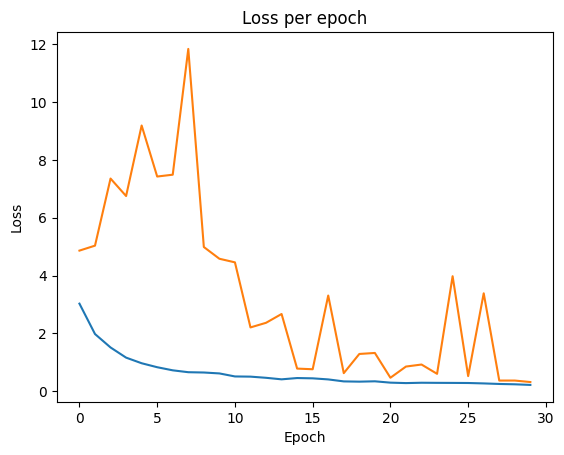

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

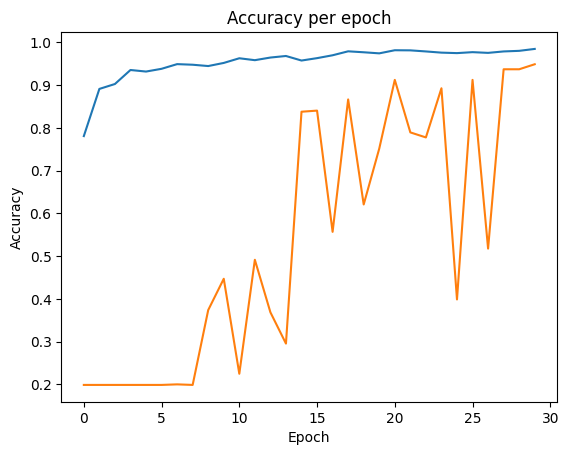

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()